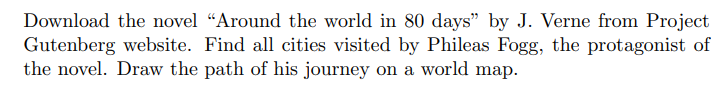

In [1]:
import re
import numpy as np
import time
from geopy.geocoders import Nominatim
import math
from geopy.distance import great_circle
import folium

In [4]:
def FindCities(filename,eclue_words):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    from_to_pattern = r'rom\s+([^:,\n]+?)\s+to\s+([A-Za-z\s]+)' # From to pattern
    from_to_matches = re.findall(from_to_pattern, text)
    
    left_reached_pattern = r'(Left|Reached)\s+([A-Za-z\s]+)' # left reached pattern
    left_reached_matches = re.findall(left_reached_pattern, text)

    city_routes = []

    for from_city, to_city in from_to_matches:
        first_word = from_city.strip().split()[0]  # Get the first word after "From"
        if first_word.lower() not in exclusion_words:
            city_routes.append((from_city.strip(), to_city.strip()))

    routes= [(action, city.strip()) for action, city in left_reached_matches] 
    filtered_routes = []
    
    for i in range(0, len(routes), 2):
        if i + 1 < len(routes):
            filtered_routes.append((routes[i][1], routes[i + 1][1].split()[0]))

    combined_routes = city_routes + filtered_routes
    
    return combined_routes

filename = '80days.txt'
special_words = ['one', 'time','the','hand','top','end','ten','right'] 
city_routes = FindCities(filename, special_words)
print(city_routes)

[('cellar', 'garret'), ('London', 'Suez via Mont Cenis and Brindisi'), ('Suez', 'Bombay'), ('Bombay', 'Calcutta'), ('Calcutta', 'Hong Kong'), ('Hong Kong', 'Yokohama'), ('Yokohama', 'San Francisco'), ('San Francisco', 'New York'), ('New York', 'London'), ('England', 'India by the Cape of Good Hope was\nabridged by at least a half'), ('Suez', 'Aden'), ('Suez directly', 'Bombay'), ('Bombay', 'Calcutta in three days'), ('here', 'Allahabad'), ('Bombay', 'Calcutta'), ('Kholby', 'Allahabad'), ('Calcutta', 'Hong Kong only comprised some three thousand five hundred\nmiles'), ('country', 'country'), ('Passepartout', 'his master would ruin all'), ('America', 'Europe is only a step'), ('Yokohama', 'San Francisco\nmade a direct connection with that from Hong Kong'), ('here. In going', 'Shanghai we should not be forced to sail wide of the Chinese coast'), ('England', 'the United States'), ('copper-colour', 'a dead white'), ('Hong Kong', 'Shanghai on the'), ('Yokohama', 'San Francisco\nbelonged to t

In [5]:
filtered_tuples = []
for a, b in city_routes:
    a_words = [word for word in a.split() if word.istitle()]
    b_words = [word for word in b.split() if word.istitle()]
    
    if a_words and b_words:
        filtered_tuples.append((" ".join(a_words), " ".join(b_words)))

print(filtered_tuples)

[('London', 'Suez Mont Cenis Brindisi'), ('Suez', 'Bombay'), ('Bombay', 'Calcutta'), ('Calcutta', 'Hong Kong'), ('Hong Kong', 'Yokohama'), ('Yokohama', 'San Francisco'), ('San Francisco', 'New York'), ('New York', 'London'), ('England', 'India Cape Good Hope'), ('Suez', 'Aden'), ('Suez', 'Bombay'), ('Bombay', 'Calcutta'), ('Bombay', 'Calcutta'), ('Kholby', 'Allahabad'), ('Calcutta', 'Hong Kong'), ('America', 'Europe'), ('Yokohama', 'San Francisco Hong Kong'), ('In', 'Shanghai Chinese'), ('England', 'United States'), ('Hong Kong', 'Shanghai'), ('Yokohama', 'San Francisco Pacific Mail Steamship Company'), ('San Francisco', 'New York'), ('New York', 'Liverpool'), ('London', 'Aden'), ('Aden', 'Bombay'), ('Calcutta', 'Singapore'), ('Singapore', 'Yokohama'), ('New York', 'San Francisco'), ('Omaha. The San Francisco', 'Sacramento'), ('Omaha', 'San Francisco'), ('Havre', 'Southampton Phileas Fogg'), ('New York', 'Liverpool'), ('New York', 'Bordeaux'), ('New York', 'Liverpool'), ('Dublin', 'Liv

In [8]:
tuples_to_remove = [
    ('In', 'Shanghai Chinese'),
    ('Omaha. The San Francisco', 'Sacramento'),
    ('America', 'Europe'),
    ('Yokohama', 'San Francisco Hong Kong'),
    ('Yokohama', 'San Francisco Pacific Mail Steamship Company'),
    ('England', 'India Cape Good Hope'),
    ('England', 'United States')

]
unique_tuples = list(set(filtered_tuples))
filter_routes = [route for route in unique_tuples if route not in tuples_to_remove]
filter_routes

[('Bombay', 'Calcutta'),
 ('Suez', 'Aden'),
 ('Omaha', 'San Francisco'),
 ('Dublin', 'Liverpool'),
 ('Suez', 'Bombay'),
 ('London', 'Paris'),
 ('Turin', 'Suez'),
 ('Paris', 'Turin'),
 ('London', 'Aden'),
 ('Hong Kong', 'Yokohama'),
 ('San Francisco', 'New York'),
 ('Singapore', 'Yokohama'),
 ('Liverpool', 'London'),
 ('Havre', 'Southampton Phileas Fogg'),
 ('Aden', 'Bombay'),
 ('London', 'Suez Mont Cenis Brindisi'),
 ('Hong Kong', 'Shanghai'),
 ('New York', 'Liverpool'),
 ('New York', 'San Francisco'),
 ('Calcutta', 'Singapore'),
 ('Calcutta', 'Hong Kong'),
 ('Yokohama', 'San Francisco'),
 ('New York', 'London'),
 ('New York', 'Bordeaux'),
 ('Kholby', 'Allahabad')]

In [12]:
unique_cities = []

for route in filter_routes:
    for city in route:
        if city not in unique_cities:  
            unique_cities.append(city)

unique_cities[-5] = 'Brindisi' 
unique_cities[-6] = 'Southampton' 
print("Cities visited by Phileas Fogg:")
print(unique_cities)

Cities visited by Phileas Fogg:
['Bombay', 'Calcutta', 'Suez', 'Aden', 'Omaha', 'San Francisco', 'Dublin', 'Liverpool', 'London', 'Paris', 'Turin', 'Hong Kong', 'Yokohama', 'New York', 'Singapore', 'Havre', 'Southampton', 'Brindisi', 'Shanghai', 'Bordeaux', 'Kholby', 'Allahabad']


In [13]:
geolocator = Nominatim(user_agent="AroundTheWorld")
positions = dict()

for city in unique_cities:
    while True:
        try:
            position = geolocator.geocode(city)
        except Exception as e:
            print(f"Error occurred: {e}. Retrying in 5 seconds...")
            time.sleep(5)
            continue
        break
    
    if position:
        location = [position.latitude, position.longitude]
        positions.update({city: location})
        del position 
    else:
        print(f"Could not get position for {city}")

positions

Could not get position for Kholby


{'Bombay': [19.08157715, 72.88662753964906],
 'Calcutta': [22.5726459, 88.3638953],
 'Suez': [29.974498, 32.537086],
 'Aden': [12.789585, 45.028504],
 'Omaha': [41.2587459, -95.9383758],
 'San Francisco': [37.7792588, -122.4193286],
 'Dublin': [53.3493795, -6.2605593],
 'Liverpool': [53.4071991, -2.99168],
 'London': [51.5074456, -0.1277653],
 'Paris': [48.8588897, 2.3200410217200766],
 'Turin': [45.0677551, 7.6824892],
 'Hong Kong': [22.350627, 114.1849161],
 'Yokohama': [35.4503381, 139.6343802],
 'New York': [40.7127281, -74.0060152],
 'Singapore': [1.357107, 103.8194992],
 'Havre': [48.5536972, -109.677802],
 'Southampton': [50.9025349, -1.404189],
 'Brindisi': [40.63591975, 17.688443357842537],
 'Shanghai': [31.2312707, 121.4700152],
 'Bordeaux': [44.841225, -0.5800364],
 'Allahabad': [25.4381302, 81.8338005]}

In [14]:
map_center = [20, 0]  
map_cities = folium.Map(location=map_center, zoom_start=2)

for city, coords in positions.items():
    folium.Marker(
        location=coords,
        popup=city,
        icon=folium.Icon(icon="plane",color='pink')
    ).add_to(map_cities)

map_cities

In [18]:
from geopy.distance import great_circle
import folium

starting_city = 'London'
route = [starting_city]
remaining_cities = {city: coords for city, coords in positions.items() if city != starting_city}

while remaining_cities:
    next_city = min(remaining_cities, key=lambda city: great_circle(positions[route[-1]], positions[city]).kilometers)
    route.append(next_city)
    del remaining_cities[next_city]


map_cities = folium.Map(location=[20, 0], zoom_start=2)


for index, city in enumerate(route, start=1):
    folium.Marker(
        location=positions[city],
        popup=f"{index}: {city}",
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12pt; color: black; background-color: white; 
                     border-radius: 5px; text-align: center;"><b>{index}</b></div>""")).add_to(map_cities)

folium.PolyLine(
    locations=[positions[city] for city in route], color='red', weight=2.5, opacity=1).add_to(map_cities)

map_cities

In [19]:

starting_city = 'London'
remaining_cities = {k: v for k, v in positions.items() if k != starting_city}

dublin_coords = remaining_cities.pop('Dublin', None)
liverpool_coords = remaining_cities.pop('Liverpool', None)

route = [starting_city]
while remaining_cities:
    next_city = find_closest_city(route[-1], remaining_cities)
    route.append(next_city)
    del remaining_cities[next_city]

if dublin_coords:
    route.append('Dublin')
if liverpool_coords:
    route.append('Liverpool')


map_center = [20, 0]
map_cities = folium.Map(location=map_center, zoom_start=2)

for index, city in enumerate(route, start=1): 
    folium.Marker(
        location=positions[city],
        popup=f"{index}: {city}", 
        icon=folium.DivIcon(
            html=f"""
                <div style="background-color: darkgreen; border-radius: 50%; width: 20px; height: 20px; display: flex; align-items: center; justify-content: center; color: white; font-weight: bold; font-size: 11pt;">
                    {index}
                </div>
            """
        )
    ).add_to(map_cities)

coords_list = [positions[city] for city in route]
folium.PolyLine(
    locations=coords_list,
    color='green',
    weight=2.5,
    opacity=1
).add_to(map_cities)

map_cities